##Anomaly detection project
**Author: Riccardo Pazzi**

In [ ]:
!pip install --upgrade scipy networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [ ]:
import networkx as nx
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import scipy

First let's import the labeled and unlabeled data

In [ ]:
annotated_df = pd.read_csv("annotated-trace.csv", names=["src_IP", "dest_IP", "service", "src_port", "dest_port" ,"target"])
test_df = pd.read_csv("not-annotated-trace.csv", names=["src_IP", "dest_IP", "service", "src_port", "dest_port"])

In [ ]:
# Keep a dataframe with only normal actions
annotated_baseline_df = annotated_df[annotated_df.target == "normal"]
annotated_anomaly_df = annotated_df[annotated_df.target != "normal"]

# keep a subset of original samples for computational reasons
input_df = pd.concat([annotated_baseline_df.iloc[:150,:], annotated_anomaly_df.iloc[:50,:]], axis=0)
big_input_df = pd.concat([annotated_baseline_df.iloc[:1000,:], annotated_anomaly_df.iloc[:50,:]], axis=0)
validation_df = pd.concat([annotated_baseline_df.iloc[150:200,:], annotated_anomaly_df.iloc[50:,:]], axis=0)
big_validation_df = pd.concat([annotated_baseline_df.iloc[1000:1200,:], annotated_anomaly_df.iloc[50:,:]], axis=0)
input_df.head()

,src_IP,dest_IP,service,src_port,dest_port,target
0,742,281,17,53,22,normal
1,241,591,6,53,53,normal
2,537,732,17,23,22,normal
3,247,200,6,20,23,normal
4,483,845,1,53,23,normal


In [ ]:
validation_df

,src_IP,dest_IP,service,src_port,dest_port,target
150,27,329,6,80,68,normal
151,744,564,6,25,53,normal
152,657,110,1,53,53,normal
153,118,656,6,80,25,normal
154,800,122,17,22,25,normal
...,...,...,...,...,...,...
9650,669,7,17,22,20,anomaly
9652,293,7,17,20,20,anomaly
9731,344,821,6,25,66,anomaly
9988,882,7,17,25,20,anomaly


In the next part the graphlet will be created starting from a list of network flows

In [ ]:
# Given flows with the same source IP returns graphlet
# Could convert service numbers to meaningful strings
def create_graphlet(list_of_flows, dense=False):
  # Create directed graph
  G = nx.DiGraph()
  for index, flow_tuple in list_of_flows.iterrows():
    G.add_edge("s" + str(flow_tuple['src_IP']), flow_tuple['service'])
    G.add_edge(flow_tuple['service'], "d" + str(flow_tuple['dest_IP']))
    G.add_edge("d" + str(flow_tuple['dest_IP']), "pf" + str(flow_tuple['src_port']))
    G.add_edge("pf" + str(flow_tuple['src_port']), "pt" + str(flow_tuple['dest_port']))
    G.add_edge("pt" + str(flow_tuple['dest_port']), "df" + str(flow_tuple['dest_IP']))
  if dense:
    return G
  # Keep only profile, remove nodes with in and out degree = 1
  for node in list(G):
    if G.in_degree(node) <= 1 and G.out_degree(node) <= 1:
      G.remove_node(node)
  return G

In [ ]:
# Test graph creation function
grouped_df = annotated_baseline_df.groupby(by="src_IP")
grouped_df.get_group(16).head()

,src_IP,dest_IP,service,src_port,dest_port,target
95,16,265,6,53,22,normal
2855,16,41,6,22,22,normal
3977,16,341,17,443,80,normal
4179,16,81,17,22,53,normal
5095,16,15,17,80,79,normal


<ipython-input-45-b57eeb273240>:2: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


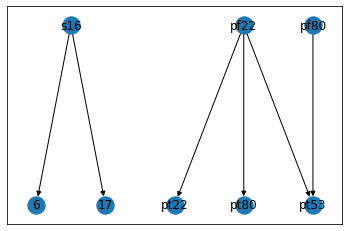

In [ ]:
graph = create_graphlet(grouped_df.get_group(16))
pos = graphviz_layout(graph, prog="dot")
nx.draw_networkx(graph, pos=pos)

In [ ]:
grouped_df.size()

src_IP
1        8
2       10
3        9
4        8
5       13
        ..
996     13
997     13
998      9
999      9
1000     7
Length: 1000, dtype: int64

The focus will now shift to creating a [0,1] column instead of normal/anomaly and the creation of the input array for the SVM

In [ ]:
# Use map function of pandas to create boolean target
target_array = input_df['target'].map({"normal": 0, "anomaly":1})
validation_target_array = validation_df['target'].map({"normal":0, "anomaly":1})

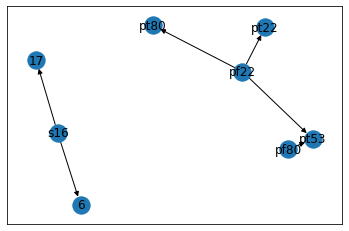

In [ ]:

# Create vector of input graphs, the graphs must contain the graphlet of the sourceIP interactions and the information about the single flow
# First store all graphlets in dictionary
graphlet_dictionary = {}
for name, _ in grouped_df:
      graphlet_dictionary[name] = create_graphlet(grouped_df.get_group(name))

nx.draw_networkx(graphlet_dictionary[16])
plt.show()

In [ ]:
# Now scan through all flows
def generate_input_from_flow(in_df):
  input_array = []
  for index, flow_tuple in in_df.iterrows():
    if(index % 500 == 0): print(f"Creating graphlet number {index}...")
    try:
      new_graphlet = graphlet_dictionary[flow_tuple['src_IP']].copy()
    except(KeyError):
      new_graphlet = nx.DiGraph()
    new_graphlet.add_edge("s" + str(flow_tuple['src_IP']), flow_tuple['service'])
    new_graphlet.add_edge(flow_tuple['service'], "d" + str(flow_tuple['dest_IP']))
    new_graphlet.add_edge("d" + str(flow_tuple['dest_IP']), "pf" + str(flow_tuple['src_port']))
    new_graphlet.add_edge("pf" + str(flow_tuple['src_port']), "pt" + str(flow_tuple['dest_port']))
    new_graphlet.add_edge("pt" + str(flow_tuple['dest_port']), "df" + str(flow_tuple['dest_IP']))
    input_array.append(new_graphlet)
  return input_array
#Call for train and validate
train_array = generate_input_from_flow(input_df)
validation_array = generate_input_from_flow(validation_df)

Creating graphlet number 0...


In [ ]:
len(validation_array)

70

In [ ]:
# Implementation of labeled direct product, not present in networkx library
from itertools import product
def _dict_product(d1, d2):
    return {k: (d1.get(k), d2.get(k)) for k in set(d1) | set(d2)}

# Generators for producting graph products
def _node_product(G, H):
    for u, v in product(G, H):
        yield ((u, v), _dict_product(G.nodes[u], H.nodes[v]))


def _directed_edges_cross_edges(G, H):
    if not G.is_multigraph() and not H.is_multigraph():
        for u, v, c in G.edges(data=True):
            for x, y, d in H.edges(data=True):
                if (u == x and v == y): yield (u, x), (v, y), _dict_product(c, d)
    else:
      print("Multigraphs are not yet supported")

def _init_product_graph(G, H):
    if not G.is_directed() == H.is_directed():
        msg = "G and H must be both directed or both undirected"
        raise nx.NetworkXError(msg)
    if G.is_multigraph() or H.is_multigraph():
        GH = nx.MultiGraph()
    else:
        GH = nx.Graph()
    if G.is_directed():
        GH = GH.to_directed()
    return GH

def labeled_tensor_product(G, H):
  GH = _init_product_graph(G, H)
  GH.add_nodes_from(_node_product(G, H))
  GH.add_edges_from(_directed_edges_cross_edges(G, H))
  return GH

Now let's create the function which will map a graph onto it's random walk feature vector

To obtain the number of walks of lenght k between any two nodes we can simply take the power k of the adjacency matrix of our graph $A^k$.
Then to obtain a vector a possible approach is to simply vertically stack all the rows or columns of the matrix.
However a problem arises: Since to compute the kernel we need to multiply two feature vectors how do we deal with vectors of different size?
We could simply pad the vectors with zeros before taking the multiplication,

In [ ]:
def generate_rw_vector(G, k=4, decay = 0.3):
  adj_matrix = nx.to_numpy_array(G)
  sum_matrix = np.zeros(adj_matrix.shape)
  for i in range(1,k+1):
    sum_matrix += (decay ** (i-1)) * np.linalg.matrix_power(adj_matrix, i)
  # Now we reshape
  feature_vector = np.reshape(sum_matrix, -1)
  return feature_vector

def compute_rwk_product(f_vector_one, f_vector_two):
  # Pad vectors before taking the dot product
  if f_vector_one.shape[0] > f_vector_two.shape[0]: 
    f_vector_two = np.pad(f_vector_two, (0, f_vector_one.shape[0] - f_vector_two.shape[0]), 'constant', constant_values=(0,0))
  else:
    f_vector_one = np.pad(f_vector_one, (0, f_vector_two.shape[0] - f_vector_one.shape[0]), 'constant', constant_values=(0,0))

  return np.dot(f_vector_one, f_vector_two)

We transform the directed graph to an undirected graph to increase the number of walks between nodes (otherwise all powers beyond the first two would be matrices of all zeroes)

In [ ]:
# Let's test the code
first_vector = generate_rw_vector(create_graphlet(grouped_df.get_group(16)).to_undirected(), 4)
second_vector = generate_rw_vector(create_graphlet(grouped_df.get_group(818)).to_undirected(), 4)
print(f"Size of first vector is: {first_vector.shape}, contains: {first_vector}")
print(f"Size of 2nd vector is: {second_vector.shape}, contains: {second_vector}")
print(f"Result of kernel product is: {compute_rwk_product(first_vector, second_vector)}")

Size of first vector is: (64,), contains: [0.708 1.18  0.    0.    1.18  0.    0.    0.    1.18  0.354 0.    0.
 0.354 0.    0.    0.    0.    0.    0.381 1.27  0.    0.381 0.408 0.09
 0.    0.    1.27  1.17  0.    1.27  1.36  0.408 1.18  0.354 0.    0.
 0.354 0.    0.    0.    0.    0.    0.381 1.27  0.    0.381 0.408 0.09
 0.    0.    0.408 1.36  0.    0.408 0.762 1.18  0.    0.    0.09  0.408
 0.    0.09  1.18  0.354]
Size of 2nd vector is: (81,), contains: [0.708 1.18  0.    0.    0.    0.    1.18  0.    0.    1.18  0.354 0.
 0.    0.    0.    0.354 0.    0.    0.    0.    0.381 1.27  0.18  0.435
 0.    0.    0.435 0.    0.    1.27  1.251 0.87  1.45  0.    0.    1.45
 0.    0.    0.18  0.87  0.816 1.36  0.    0.    1.36  0.    0.    0.435
 1.45  1.36  0.843 0.    0.    0.843 1.18  0.354 0.    0.    0.    0.
 0.354 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.435 1.45  1.36  0.843 0.    0.    0.843]
Result of kernel product is: 10.884432


We can compute all of the feature vectors and then check which is the vector with the largest size, then pad all other vectors with zeroes to match the size of the biggest one:

In [ ]:
feature_vectors = []
homogeneous_f_vectors = []
max_size = 400
big_train_array = generate_input_from_flow(big_input_df)
big_validation_array = generate_input_from_flow(big_validation_df)
big_target_array = big_input_df['target'].map({"normal": 0, "anomaly":1})
big_validation_target_array = big_validation_df['target'].map({"normal":0, "anomaly":1})
for graph in big_train_array:
  vector = generate_rw_vector(graph, k=4)
  feature_vectors.append(vector)
  if len(vector) > max_size: max_size = len(vector)

print(f"Largest size is: {max_size}")

for f_vector in feature_vectors:
  homogeneous_f_vectors.append(np.pad(f_vector, (0, max_size - len(f_vector)), 'constant', constant_values=(0,0)))

Creating graphlet number 0...
Creating graphlet number 500...
Creating graphlet number 1000...
Largest size is: 400


In [ ]:
classifier = svm.SVC(kernel="rbf")
classifier.fit(homogeneous_f_vectors, big_target_array)

SVC()

Now let's test the trained model:

In [ ]:
max_size = 400
val_homogeneous_f_vectors = []
val_feature_vectors = []
for graph in big_validation_array:
  vector = generate_rw_vector(graph, k=4)
  val_feature_vectors.append(vector)
  if len(vector) > max_size: max_size = len(vector)

print(f"Largest size is: {max_size}")

for f_vector in val_feature_vectors:
  val_homogeneous_f_vectors.append(np.pad(f_vector, (0, max_size - len(f_vector)), 'constant', constant_values=(0,0)))

Largest size is: 400


In [ ]:
classifier.score(val_homogeneous_f_vectors, big_validation_target_array)

0.9136363636363637

In [ ]:
classifier.predict(val_homogeneous_f_vectors)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

We can observe how only a single anomaly was correctly detected, this could be either because of the unbalance of the training set or due to the too high dimensionality of feature vectors. We are using 400 dimensional feature vectors but train the model only on 50 anomaly samples, this is clearly a problem since it's hard to find a good boundary in the 400d space with such a limited sample size.

Finally let's use the kernel trick to compute the similarity between two graphs:

In [ ]:
from networkx.linalg.graphmatrix import adjacency_matrix

def random_walk_kernel(G, H, decay_lambda=0.3):
  # Takes two graphs as input G and H and returns the RWK function
  product_graph = labeled_tensor_product(G, H)
  adj_matrix = nx.to_numpy_array(product_graph)
  if(adj_matrix.shape[0] == adj_matrix.shape[1]): 
    size = adj_matrix.shape[0]
    # print(f"Size of adjacency matrix is {size}")
  e_vector = np.ones(size)
  return e_vector.T.dot(np.linalg.inv(np.identity(size)-decay_lambda * adj_matrix)).dot(e_vector)

def vectorized_rwk(vec_G, vec_H):
  Gram_matrix = np.zeros((len(vec_G), len(vec_H)))
  update_size = len(vec_G) / 20.0
  for index_row, G in enumerate(vec_G):
    if(index_row % update_size == 0): print(f"Processed {5 * (index_row // update_size)}% of the data points")
    for index_col, H in enumerate(vec_H):
      Gram_matrix[index_row][index_col] = random_walk_kernel(G,H)
  return Gram_matrix

In [ ]:
# Compute labeled direct product on two random graphs
graph_one = graphlet_dictionary[16]
graph_two = graphlet_dictionary[818]
random_walk_kernel(graph_one, graph_two)

72.0

In [ ]:
# Fit the SVM on the training data
classifier = svm.SVC(kernel="precomputed")
train_kernel = vectorized_rwk(train_array,train_array)
classifier.fit(train_kernel, target_array)

Processed 0.0% of the data points
Processed 5.0% of the data points
Processed 10.0% of the data points
Processed 15.0% of the data points
Processed 20.0% of the data points
Processed 25.0% of the data points
Processed 30.0% of the data points
Processed 35.0% of the data points
Processed 40.0% of the data points
Processed 45.0% of the data points
Processed 50.0% of the data points
Processed 55.0% of the data points
Processed 60.0% of the data points
Processed 65.0% of the data points
Processed 70.0% of the data points
Processed 75.0% of the data points
Processed 80.0% of the data points
Processed 85.0% of the data points
Processed 90.0% of the data points
Processed 95.0% of the data points


SVC(kernel='precomputed')

In [ ]:
# Validate our SVM on the validation set
validation_kernel = vectorized_rwk(validation_array, train_array)

Processed 0.0% of the data points
Processed 10.0% of the data points
Processed 20.0% of the data points
Processed 30.0% of the data points
Processed 40.0% of the data points
Processed 50.0% of the data points
Processed 60.0% of the data points
Processed 70.0% of the data points
Processed 80.0% of the data points
Processed 90.0% of the data points


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [ ]:
classifier.score(validation_kernel, validation_target_array)

1.0

We can observe how all anomalies are identified corrently even with a limited training set of only 200 flows. Let's now predict the part of the test set and check the results:

In [ ]:
# Use the first 200 test samples
test_array = generate_input_from_flow(test_df.iloc[:200,:])
test_kernel = vectorized_rwk(test_array, train_array)

Creating graphlet number 0...
Processed 0.0% of the data points
Processed 5.0% of the data points
Processed 10.0% of the data points
Processed 15.0% of the data points
Processed 20.0% of the data points
Processed 25.0% of the data points
Processed 30.0% of the data points
Processed 35.0% of the data points
Processed 40.0% of the data points
Processed 45.0% of the data points
Processed 50.0% of the data points
Processed 55.0% of the data points
Processed 60.0% of the data points
Processed 65.0% of the data points
Processed 70.0% of the data points
Processed 75.0% of the data points
Processed 80.0% of the data points
Processed 85.0% of the data points
Processed 90.0% of the data points
Processed 95.0% of the data points


In [ ]:
predictions_array = classifier.predict(test_kernel)
predictions_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In the first 200 samples we find one candidate anomaly, let's investigate:

In [ ]:
np.where(predictions_array == 1)

(array([58]),)

The anomaly is at index 58, let's open it from the DataFrame:

In [ ]:
test_df.iloc[58]

src_IP       982
dest_IP        7
service       17
src_port      23
dest_port     53
Name: 58, dtype: int64

And let's check the activity graph of IP 982:

<ipython-input-142-626b4dff717c>:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


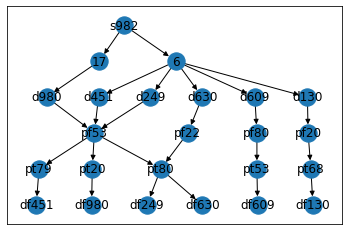

In [ ]:
grouped_df = annotated_df.groupby(by="src_IP")
graph = create_graphlet(grouped_df.get_group(982), dense = True)
pos = graphviz_layout(graph, prog="dot")
nx.draw_networkx(graph, pos=pos)

This is the activity graph during the training phase, let's compare it to the activity graph in the testing phase

<ipython-input-143-a280c58ea18c>:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


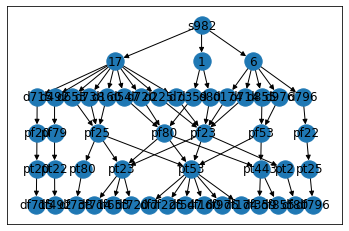

In [ ]:
grouped_df = test_df.groupby(by="src_IP")
graph = create_graphlet(grouped_df.get_group(982), dense = True)
pos = graphviz_layout(graph, prog="dot")
nx.draw_networkx(graph, pos=pos)

We can clearly observe a difference in behaviour, particularly the number of unique IPs the host is contacting. Relevant target ports used are: 80 (HTTP), 53 (DNS), 25 (SMTP), 22 (SSH), 23(TelNet), 443 (HTTPS)To further analyze the communications it would be interesting to check an activity graph which contains 982 as the target for communication.

<ipython-input-144-89ea89f1fdd5>:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


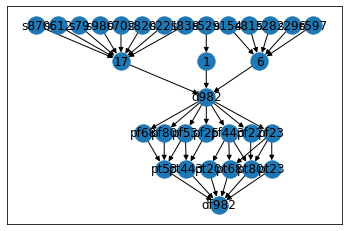

In [ ]:
grouped_df = test_df.groupby(by="dest_IP")
graph = create_graphlet(grouped_df.get_group(982), dense = True)
pos = graphviz_layout(graph, prog="dot")
nx.draw_networkx(graph, pos=pos)

<ipython-input-145-e6187cc61663>:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


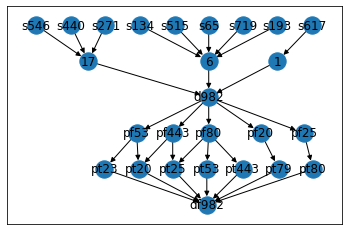

In [ ]:
grouped_df = annotated_df.groupby(by="dest_IP")
graph = create_graphlet(grouped_df.get_group(982), dense = True)
pos = graphviz_layout(graph, prog="dot")
nx.draw_networkx(graph, pos=pos)

Nothing stands out in this other graph, a guess as to why this flow was labeled anomalous could be the unexpected traffic, and ports seem to suggest this could be a router handling HTTP/HTTPS and DNS requests.
We could compare the topology with the ones presented in the BLINC paper[1] but the graphlet does not resemble any attack pattern. In general having the flow flagged by the model does not guarantee that the prediction is correct, moreover due to resource and dataset balance constraint this model was trained on a small dataset (200 samples) meaning the results might significantly improve with more data. Also anomaly does not necessarily imply an attack is happening, in this case for example there is no clear attack happening, the increased volume might have caused a different distribution in the flows causing the system to identify it as anomalous.

# References

[1] BLINC: Multilevel Traffic Classification in the Dark, T. Karagiannis K. Papagiannaki, M. Faloutsos, ACM SIGCOMM Computer Communication Review, Volume 35, Issue 4, October 2005